# Evaluación y Uso de YOLOv8 para detección de pólipos

## Introducción

En este notebook, exploramos y evaluamos el rendimiento del modelo [**YOLOv8**](https://docs.ultralytics.com/models/yolov8/)
para la detección de pólipos cancerosos en imágen médica de colonoscopias.

Para ello utilizaremos el dataset de [**Piccolo**](https://huggingface.co/hustvl/yolos-base) combinado en entrenamiento con el dataset [CVC](https://polyp.grand-challenge.org/CVCClinicDB/),
este conjunto de datasets proporciona imágenes de colonoscopias tanto en RGB como en NBI,
y combinar ambos en entrenamiento nos dará mas variedad y cacapidad de generalización.
Para la detección **modificaremos el modelo** el modelo para detectar los pólipos
usando bboxes.

### Objetivos

- Modificar el modelo **YOLOv8** para la detección de pópipos con bounding boxes.
- Entrenar el modelo con las imágenes medicas seleccionadas haciendo un **fine-tunning** para imágen médica.
- Mostar el rendimiento del mismo con el benchamark del modelo seleccionado

¡Comencemos con la evaluación del modelo!
## Pasos a seguir

1. Cargamos y analizamos los **datasets**
2. **Procesamos los datos** para cumplir con el formato de entrada del modelo
3. Cargamos y **modificamos el modelo** para detección de pólipos
4. **Entrenamos** el modelo con los datos obtenidos
4. **Evaluamos** el rendimiento

### 1- Cargar y analizar el dataset

Como hemos mencionado cargaremos el datset de [**Piccolo**](https://www.biobancovasco.bioef.eus/en/Sample-and-data-catalog/Databases/PD178-PICCOLO-EN.html),
el cuál tiene una cantidad rezonable de imágenes en RGB y NBI categorizadas por 
al pólipo al que pertenecen por lo que podemos usar la división pre hecha del dataset
y evitar asignar frames del mismo pólipo al train y validation invalidando los relustados.

Además usaremos el dataset [CVC](https://polyp.grand-challenge.org/CVCClinicDB/)
para enriquecer a Piccolo en entrenamiento y evitar que generalice mal

Además mostraré informaciñon relevante de las imágenes escogidas

In [9]:
import sys
import os

path_to_add = os.path.abspath('../../utils')
if path_to_add not in sys.path:
    sys.path.append(path_to_add)

from utils import ImageDatasetProcessor as idp

DS_PATH = "../../datasets"
DS_NAME = "Piccolo+CVC"
json_path = f"{DS_PATH}/piccolo_dataset/{DS_NAME}_dict.json"

# paths del dataset
paths_img = [
    # train paths
    (DS_PATH + "/piccolo_dataset/test/polyps",                      # polyps
     DS_PATH + "/piccolo_dataset/test/masks",                       # masks
     DS_PATH + "/piccolo_dataset/test/void", "test"  ,              # voids
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),      # light type

    # test paths
    (DS_PATH + "/piccolo_dataset/train/polyps",
     DS_PATH + "/piccolo_dataset/train/masks",
     DS_PATH + "/piccolo_dataset/train/void", "train",
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),

    # validation paths
    (DS_PATH + "/piccolo_dataset/validation/polyps",
     DS_PATH + "/piccolo_dataset/validation/masks",
     DS_PATH + "/piccolo_dataset/validation/void", "validation",
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv")]

# inicializamos el dataset con su nombre y fichero de formatos de imagen
dt_Piccolo = idp(target_resolution=(400, 240), dataset_name=DS_NAME,
                     json_path=json_path)

# procesamos el dataset si no existe el json
if not os.path.isfile(json_path):
    for path in paths_img:
        print(f"procesando conjunto: {path[3]}")
        dt_Piccolo.load_dataset(path[0], path[1], voids_path=path[2], 
                                split=path[3], light_csv=path[4])

#### Análisis del dataset
Como podemos ver es un dataset muy ordenado, con una cantidad representativa de
imágenes NBI por lo que es adecuado para el entrenamiento en ambos tipos de luz 
(WL, NBI).

Además podemos observar que es un dataset con una distribución de los pólipos
más o menos descentralizada. Y señalar que usaremos la división del propio dataset,
 es decir, usaremos el split base de train, test y validation ya que este es 
 **distribuye los pólipos** no las imagenes aleatoriamente,
 **evitando tener imágenes del mismo pólipo en train y validation**, añadiremos 
 al conjunto base de train las imágenes del dataset CVC

In [10]:
dt_Piccolo.print_summary()

Total imágenes: 4045
Composición del dataset:
Resoluciónes: total distintas resoluciones 3
	480x854: 1972	1080x1920: 1461	288x384: 612

Tipos de luz:
	WL: 2131	NBI: 1302	Unknown: 612

Splits:
	test: 333	train: 2815	validation: 897

Canales:
	polyp_RGB: 4045	mask_L: 4045	void_L: 3433

Volumen medio de los pólipos respecto a la imagen:	18.52638097233012%
Distancia media del centro del pólipos al centro de la imagen:	60.29317555516509px


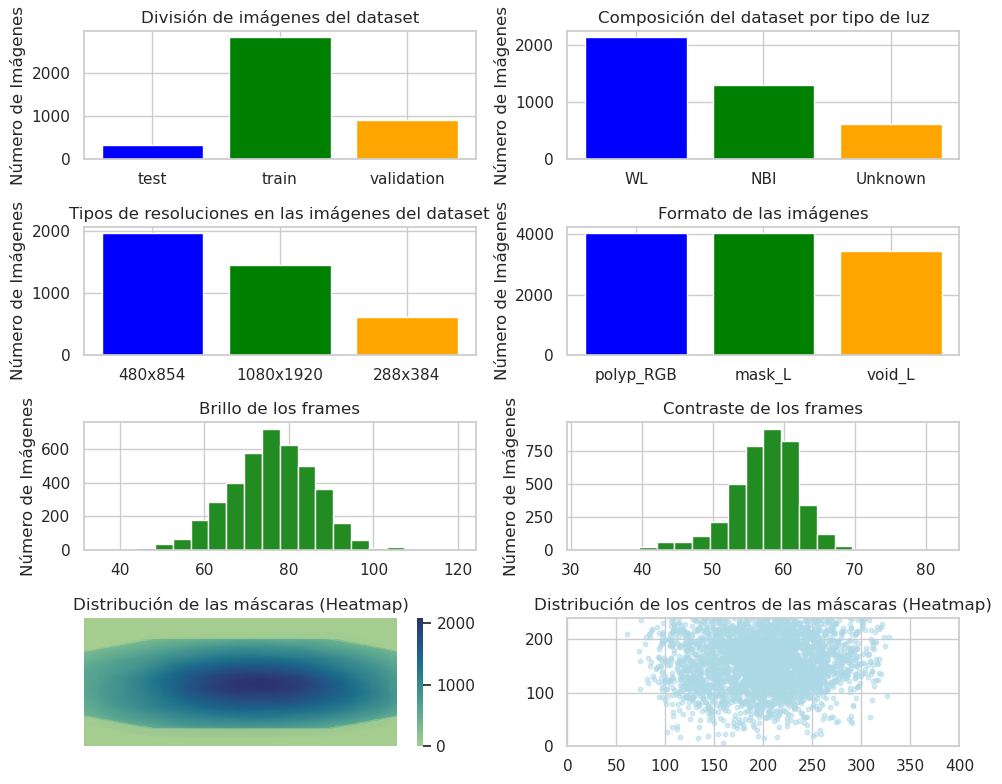

In [11]:
dt_Piccolo.graph_summmary()

Finalmente veamos una muestra de una imágen aleatoria y su aspecto con la bbox

Imagen 019_VP22_frame1062.png	bbox: (241, 241, 452, 238)


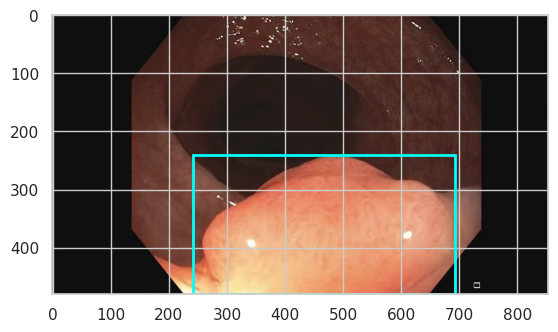

In [12]:
import random

# mostramos aleatoriamente una imágen del dataset
rand_key = random.choice(list(dt_Piccolo.dict.keys()))
dt_Piccolo.show_image(rand_key)

## Entrenamiento de YOLO

Para esta segunda entrenaremos el modelo de [YOLOv8](https://docs.ultralytics.com/models/yolov8/)
con las imágenes del dataset de Piccolo, con la peculiaridad que trataremos con 
un modelo modificado para devolver solo las bboxes.

#### Pasos del entrenemiento
1. **Modificaremos el modelo** para hacer un fine-tunning del modelo y devolver tan solo las bboxes. Yolov8 tiene una librería personalizada para entrenar el modelo, 
pero nosotros solo queremos que detecte las bboxes y ignorar la clasificación, poer lo que modificaremos el modelo.

2. **Preparar todo para el entrenamiento**, esto son elementos como el 
optimizador y la función de pérdida además de juntar definitivamente los datos
en los splits adecuados y DataLoaders para usarlos en la función de entrenamiento

3. **Entrenar** el modelo y ir obteniendo datos del rendimiento del mismo para
poder mostrarlos más adelante

### Modificar el modelo para Fine-Tunning
En este caso el modelo de **YOLOv8** tiene un modelo de la **librería de ultralitics**
de este modelo **la salida** es un tensor de predicciones intermedio, una salida 
del encoder sin significado literal, por lo que debemos tratarla con los siguientes pasos:

1. Obtenemos la salia del modelo con el tensor de predicciones intermedios **[batch_size, 144, 80, 80]** es decir, 144 predicciones de 80x80 caracteristicas
2. Reestructuramos el tensor para obtener las predicciones de forma legible con la función de libreria view
3. Obtenemos los datos requeridos con la forma 
**[batch_size, num_preds, (x_center, y_center, width, height, COCO_class, confianza)]**
4. Obtenemos una bbox ponderada, esto es que cada bbox predicha se tiene en cuenta
por el porcentage normalizado de la confianza en esa bbox, haciendo que todas
las predicciones se tengan en cuenta y **las bboxes con más confianza determinen más la bbox final**. Esto se hace para cada muestra del batch dejando la salida como
**[batch_size, best_bbox]**

In [13]:
import torch.nn as nn
import torch
from ultralytics.utils.ops import non_max_suppression


"""
    Vamos a modificar la salida de YOLOv8 para obtener uhna única salida con 
    una bbox ya que es lo que buscamos con nuestro modelo.
"""
class DetectionYOLOv8(nn.Module):
    def __init__(self, yolov8_model):
        super(DetectionYOLOv8, self).__init__()  # iniciamos la clase padre antes evitar errores
        self.model = yolov8_model

        # El modelo viene precongelado, hay que descongelarlo para el fine-tunning
        for param in self.model.parameters():
            param.requires_grad = True

    """
    Modificamos la salida de [batch_size, num_pred, 6] siendo la útlima dimension;
    (x_center, y_center, width, height, confidence, class_id) para tener simplemente
    la bbox en formato YOLO: (x_center, y_center, width, height)
    """
    def forward(self, x):
        # x es la entrada de la imagen
        inter_results = self.model(x)[0]  # obtenemos el tensor de predicciones intermedio
        bboxes = []

        # Usamos .view() para reestructurar
        # Convertimos de [B, 144, 80, 80] a [B, 144, num_preds]
        inter_results = inter_results.view(inter_results.shape[0], 144, -1)  

        # Para cada predicción, tomamos las 4 primeras columnas: (x_center, y_center, width, height) y las clases
        pred_bboxes = inter_results[..., :4]  # Coordenadas de la bbox
        confs = inter_results[..., 4:5]       # Confianza

        # Convertimos las predicciones a la forma [B, num_preds, 6]
        preds = torch.cat([pred_bboxes, confs], dim=-1)

        # obtenemos la confianza en las predicciones normalizada 
        weights = torch.softmax(confs, dim=1)

        # obtenemos la bbox media según la confianza en cada predicción
        weighted_bbox = (pred_bboxes * weights).sum(dim=1)

        return {'pred_bboxes': weighted_bbox}

#### Preparar el entrenamiento
Una vez modificado el modelo solo debemos preparar el entrenamiento, es decir:
- Definir los dataloders
- Cargar el modelo personaliazdo
- Definir las funciones de pérdida y optimizadores
- Definir una fuinciñon de entrenamiento

Utilizaremos el **optimizador Adalain** ya que es el usado en Yolos-base y la 
**loss fuction smooth_l1_loss** para las bbox de la salida ya que es información contínua

In [14]:
import torch
from ultralytics import YOLO

model = DetectionYOLOv8(YOLO('yolov8n.pt').model)
model.train()

DetectionYOLOv8(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, trac

#### Entrenamiento

Ahora por fin pasamos a entrenar el modelo y recopilar los dátos de análisis 
para ellos obtenemos el IoU de las bboxes, ya que al ser areas en al imágen no 
podemos medir un "accuracy" tal cual.

**IoU** es una métrica usada para este
tipo de situaciones en las que se calcula: **IoU=Area_interseccion/Area_union** 
por lo que es importante tener en cuenta que **un IoU 1 es una coincidencia exacta**

In [15]:
from utils import TrainModel as trm
from torch.optim import AdamW
import json

# definimos los parametros del entrenamiento 🏃‍♂
MODEL_NAME = "YOLOv8"
NUM_EPOCH = 60              # 🔄 Numero de epocas del entrenamiento 
BATCH_SIZE = 10             # 👝 Numero de imágenes por batch
TRAIN_RES = (384, 384)      # 📷 Resolucion entreno, respetamos la proporción 16/9
RESULTS_JSON = f"../../resultados/{DS_NAME}_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}.json"
RESULTS_IMG = f"../../resultados/{DS_NAME}_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}.png"
json_exists = False

# Obtener los diccionarios con formato de entrenamiento
train_loader, val_loader, test_loader = dt_Piccolo.get_dataloaders(
                                            BATCH_SIZE, use_premade_splits=True)

# definimos el optimizador y la loss function
def loss_fn(target, pred):
    return nn.functional.smooth_l1_loss(pred, target)

optimizer = AdamW(model.parameters(), lr=5e-5)
trainer = trm(model, loss_fn=loss_fn, optim=optimizer)

# si ya tenemos los resulados no volvemos a entrenar
if os.path.isfile(RESULTS_JSON):
    with open(RESULTS_JSON, "r", encoding="utf-8") as json_file:
            train_results = json.load(json_file)
    json_exists = True

if not json_exists:
    train_results = trainer.train_model(NUM_EPOCH, TRAIN_RES, 
                                    train_loader, val_loader, test_loader)

    # guardamos los datos
    with open(RESULTS_JSON, "w", encoding="utf-8") as json_file:
        json.dump(train_results, json_file)  # `indent=4` para formato legible

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (3): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (4): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0-1): 2 x Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (5): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (6): C2f(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0-1): 2 x Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (7): Conv(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (8): C2f(
        (cv1): Conv(
          (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (9): SPPF(
        (cv1): Conv(
          (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
      )
      (10): Upsample(scale_factor=2.0, mode='nearest')
      (11): Concat()
      (12): C2f(
        (cv1): Conv(
          (conv): Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (13): Upsample(scale_factor=2.0, mode='nearest')
      (14): Concat()
      (15): C2f(
        (cv1): Conv(
          (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (16): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (17): Concat()
      (18): C2f(
        (cv1): Conv(
          (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (19): Conv(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (20): Concat()
      (21): C2f(
        (cv1): Conv(
          (conv): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (22): Detect(
        (cv2): ModuleList(
          (0): Sequential(
            (0): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): Sequential(
            (0): Conv(
              (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): Sequential(
            (0): Conv(
              (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (cv3): ModuleList(
          (0): Sequential(
            (0): Conv(
              (conv): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): Sequential(
            (0): Conv(
              (conv): Conv2d(128, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): Sequential(
            (0): Conv(
              (conv): Conv2d(256, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (dfl): DFL(
          (conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
      )
    )
  )
)

## Análisis de los resultados

Una vez entrenado el modelo y finalizada la obtencion de datos durante el entrenamiento,
además de disponer de los datos de test vamos a graficar los resultados y ver 
que tal ha ido el entrenamiento.

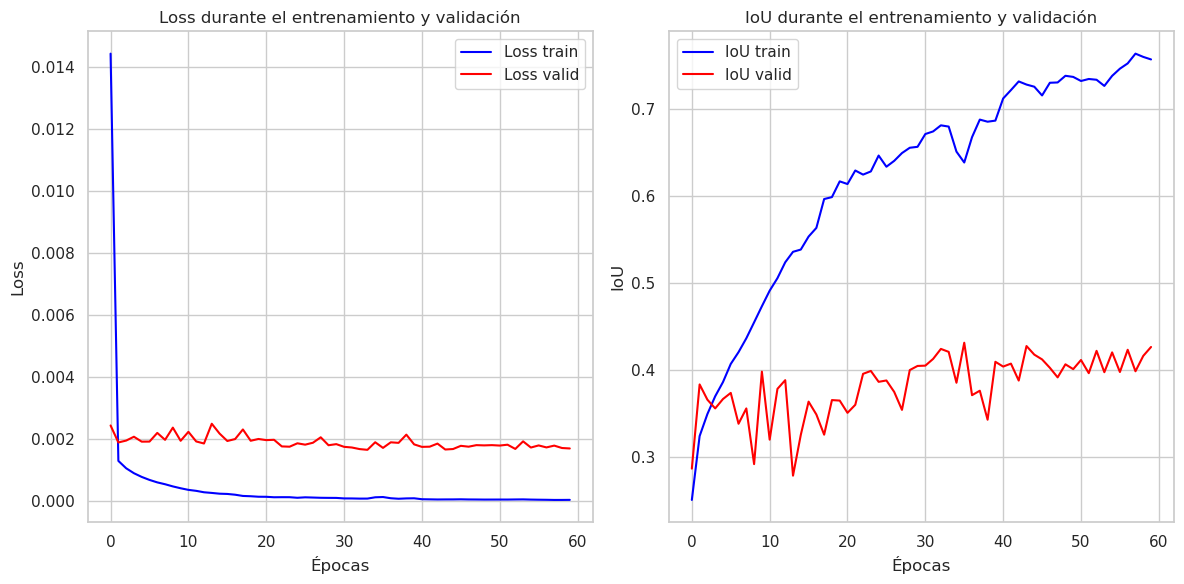

End of training!
-------------------- FINAL RESULTS ------------------------
|     - Test loss:     0.0016442725134417373                         |
|     - Test IoU: 0.2717488174356084                         |
-----------------------------------------------------------


In [16]:
trainer.show_results(train_results, save_img=True, img_name=RESULTS_IMG)